# Bayesian non parametric for ranked data

## Finite Placket-Luce model
\begin{itemize}
\item Goal : modeling partial rankings of a finite collection of $M$ items.

\item Each item $k\in [M]$ is assigned to a positive ranking parameter $w_k$ (desirability).

\item We consider a top-$m$ list $\rho=(\rho_1,\cdots,\rho_m)$ of items of $[M]$, as follows : 

At each stage $i=1,\cdots,m$, an item is chosen among the items that have not been chosen yet, with probability proportional to its desirability. The probability that a list $\rho$ is chosen is then :
\[
P(\rho) = \prod_{i=1}^m\frac{w_{\rho_i}}{\left(\sum_{k=1}^M w_k\right) -\left(\sum_{j=1}^{i-1}w_{\rho_j}\right)}
\]

For each item $k$ of the list, the denominator is the sum of the score of object not yet chosen.

An alternative Thurstonian interpretation is the following, for each item $k$ we draw $z_k$ from a exponential law with parameter $w_k$. Then we order the items with increasing $z_k$ which can be seen as the time of arrival. The probability of a ranking can be shown to be the same as 

\end{itemize}

### Toy example

In [3]:
import numpy as np

players = np.array(["Navas", "Marquinhos", "Silva", "Kimpembe", "Meunier", "Gueye", "Verratti", "Kurzawa", "Di Maria", "Neymar",\
"Mbappé"])
#, "Burki", "Piszczek", "Hummels", "Zagadou", "Hakimi", "Can", "Witsel", "Guerreiro", "Sancho", "Hazard", \"Haaland"]

ratings = np.array([5,5,4,4,4,3,6,5,3,4,4])
#,6,6,6,6,7,7,8,6,7,6,8]

dic_object_rating = {players[i]: ratings[i] for i in range(len(players))} 

def draw_ranking(items, ratings, length):
    ranking = np.random.choice(items,length,replace = False, p = ratings/np.sum(ratings)) 
    return ranking
    
rank = draw_ranking(players, ratings, 11)
print(rank)

def draw_ranking_thurstonian(items, ratings, length):
    arrival = np.random.exponential(1/ratings,length)
    index = np.argsort(arrival)
    return np.array(items)[index]
    

rank = draw_ranking_thurstonian(players, ratings, 11)
print(rank)


['Navas' 'Marquinhos' 'Neymar' 'Mbappé' 'Gueye' 'Kimpembe' 'Verratti'
 'Silva' 'Meunier' 'Di Maria' 'Kurzawa']
['Verratti' 'Marquinhos' 'Gueye' 'Kimpembe' 'Kurzawa' 'Silva' 'Neymar'
 'Mbappé' 'Meunier' 'Navas' 'Di Maria']


Let's compute the probability of a ranking by Monte Carlo.

In [320]:
def monte_carlo(ranking,dic_object_rating, draw =10000, mode="normal"):
    """
    Function that estimate the probability of a ranking by monte_carlo and compute its true probability   
    (the number of object is the length of the ranking)
    """
    weights = np.array([dic_object_rating[item] for item in ranking])
    p = np.product(weights/np.cumsum(weights[::-1]))
    
    N = 0
    for i in range(draw):
        if mode == "normal":      
            rank = draw_ranking(ranking, weights, len(ranking))       
        else : 
            rank = draw_ranking_thurstonian(ranking, weights, len(ranking))   
        if (rank == ranking).all():
            N += 1
    return p, N/draw

# let's say we have only 3 players to rank 
# (because the probability to obtain a given ranking is to small for more player)
ranking = ['Kimpembe', 'Mbappé' ,'Marquinhos']

p_true, p_estim_normal = monte_carlo(ranking,dic_object_rating, draw =10000, mode = "normal")
p_true, p_estim_thursto = monte_carlo(ranking,dic_object_rating, draw =10000, mode = "nor")
    
print(p_true, p_estim_normal, p_estim_thursto)

0.13675213675213677 0.1331 0.1407


## Bayesian Placket-Luce model


Let's assume there are $L$ partial rankings $\rho_l=(\rho_{l1},\cdots,\rho_{lm})$ of length $m$. With $M$ choice of item. As seen previously we can consider latent variables to compute the rating. With $z_{lk}\sim\text{Exp}(w_k)$ such that $\rho_{li}$ correspond to $i$-th smallest value among the $z_{lk}$
It is possible to compute the joint posterior distribution of $Z_{li}\doteq z_{\rho_{li}}-z_{\rho_{l,i-1}}$ and $\rho_l$ knowing $w_k$.

$$
P\left( (\rho_l),(Z_{li}) \vert (w_k) \right) = \prod_{l=1}^L\prod_{i=1}^m w_{\rho_{li}} \exp \left( -Z_{li}\left(\sum_{k=1}^M w_k-\sum_{j=1}^{i-1} w_{\rho_{lj}} \right) \right)
$$
 
if $w_k\sim\text{Gamma}\left(\frac{\alpha}{M},\tau\right)$, then :
\[
w_k\vert (\rho_l),(Z_{li}),(w_{k'})_{k'\neq k} \sim \text{Gamma}\left(\frac{\alpha}{M}+n_k,\tau +\sum_{l=1}^L\sum_{i=1}^m \delta_{lik}Z_{li}\right)
\] 

With $\delta_{l i k}$ the occurence indicator:

\[
\delta_{l i k}=\left\{\begin{array}{ll}
0 & \text { if } \exists j<i \text { with } Y_{l j}=X_{k}^{*} \\
1 & \text { otherwise }
\end{array}\right.
\]

And we have
\[
Z_{li}\vert (\rho_l,w) \sim \text{Exp}\left(\sum_{k=1}^M w_k-\sum_{j=1}^{i-1} w_{\rho_{lj}} \right)
\] 

## Bayesian non parametric Placket-Luce model
Then by taking the limit $M \rightarrow +\infty$ we have the non parametric Placket-Luce model

\[
w^*_k\vert (\rho_l),(Z_{li}),(w_{k'})_{k'\neq k} \sim \text{Gamma}\left(n_k,\tau +\sum_{l=1}^L\sum_{i=1}^m \delta_{lik}Z_{li}\right)
\label{up2}
\] 

And for items $k$ who do not appear, we define $w_* \doteq \sum_{k / n_k=0} w_k$ so that :
\[
w^*_* \vert (\rho_l),(Z_{li}),(w_k)_{k,n_k>0} \sim \text{Gamma}\left(\alpha,\tau +\sum_{l=1}^L\sum_{i=1}^m Z_{li}\right)
\label{up4}
\]

So we have for $Z_{li}$

\[
Z_{li}\vert (\rho_l,w) \sim \text{Exp}\left(w^*_*-\sum_{k}\delta_{lik} w_k \right)
\label{up1}
\] 

We also have the posterior distribution for $\alpha$ with a prior $\text{Gamma}(a,b)$

\[
\alpha \vert (\rho_l,w) \sim \text{Gamma}\left(a+K , b + \text{log}\left(1 +\frac{\sum_{l=1}^L\sum_{i=1}Z_{li}}{\tau} \right) \right)
\label{up3}
\] 

By taking successively the update : \ref{up1} \ref{up2} \ref{up3} \ref{up4} we have a gibbs sampler

In [335]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

    
class gibbs_sampler_for_ranked_data():
    """
    input : a list of ranking (list of list)
    a,b = prior for alpha
    
    output : their score
    
    """
    def __init__(self, a = 10, b = 1):
        """
        dict_item_to_number : dictionary mapping the object (str) to number
        N : number of apparition of an item
        delta_lik : occurence indicator
        
        """
        self.rankings = None
        self.dict_item_to_number = {}
        self.K = 0 #number of items
        
        self.alpha = 0 # no sure fore the moment
            
        # Observable used to sample
        self.N = [] 
        self.delta_lik = None
        
        # prior
        self.tau = 1
        # prior for gamma
        self.a = a
        self.b = b
        
        
        pass
      
    def fit(self, rankings, sampling = 1000, burn_in = 1000):
        
        """
        Input : the list of ranking 
        Return : the a list of the sample of the score for each items
        
        """
        self.rankings = rankings
        self.m = len(rankings[0]) # size of the ranking
        self.L = len(rankings) # number of ranking
        
        # get the dict_item_to_number mapping
        for l,ranking in enumerate(self.rankings):
            for item in ranking:
                if item not in self.dict_item_to_number:
                    self.dict_item_to_number[item] = self.K
                    self.K += 1
                    self.N.append(0)
                self.N[self.dict_item_to_number[item]] +=1
        
        
        self.delta_lik = np.ones((self.L,self.m,self.K))
        
        for l,ranking in enumerate(self.rankings):
            for item,k in self.dict_item_to_number.items():
                if item in ranking:
                    position = ranking.index(item)
                    if position+1 < self.m:
                        self.delta_lik[l,position+1:,k] = 0
        
        self.w_k = np.ones((self.K))
        for k in range(self.K):
            self.w_k[k] = np.random.gamma(self.N[k], self.tau)
            
        
        self.Zli = np.zeros((self.L,self.m))
        self.w_star = 0

        for step in range(burn_in): 
            # Sampling of Z_li
            for l in range(self.L): 
                for i in range(self.m):
                    self.Zli[l,i] = np.random.exponential(scale=1/ (self.w_star + np.sum(self.delta_lik[l,i]*self.w_k) ))
            
            for k in range(self.K):
                self.w_k[k] = np.random.gamma(self.N[k], scale=self.tau + np.sum(self.Zli*self.delta_lik[:,:,k]), size=None)
                
                
            self.alpha = np.random.gamma(self.a + self.K, scale= self.b + np.log(1+ np.sum(self.Zli)/self.tau), size=None)
            
            self.w_star = np.random.gamma(self.alpha, scale= self.tau + np.sum(self.Zli), size=None)
            
        self.w_list = [self.w_k.copy()]
        self.w_star_list = [self.w_star]
            
        for step in range(sampling): 
            # Sampling of Z_li
            for l in range(self.L): 
                for i in range(self.m):
                    self.Zli[l,i] = np.random.exponential(scale=1/ (self.w_star + np.sum(self.delta_lik[l,i]*self.w_k) ))
            
            for k in range(self.K):
                self.w_k[k] = np.random.gamma(self.N[k], scale=self.tau + np.sum(self.Zli*self.delta_lik[:,:,k]), size=None)
                      
            self.alpha = np.random.gamma(self.a + self.K, scale= self.b + np.log(1+ np.sum(self.Zli)/self.tau), size=None)
            
            self.w_star = np.random.gamma(self.alpha, scale= self.tau + np.sum(self.Zli), size=None)
            
            self.w_list.append(self.w_k.copy())
            self.w_star_list.append(self.w_star)
                
        return (self.w_list,self.w_star_list)

In [336]:
Ranking_per_country = pd.read_csv("africa_vote.csv")
Ranking_per_country.head(5)

,Pays,Joueur 1,Joueur 2,Joueur 3,Joueur 4,Joueur 5,Journaliste,Agence
0,Afrique du Sud,Messi,Van Dijk,Cristiano Ronaldo,Mané,De Bruyne,Mark Gleeson,Reuters
1,Algérie,Mané,Messi,Mahrez,Van Dijk,Agüero,Yazid Ouahib,El-Watan
2,Angola,Van Dijk,Cristiano Ronaldo,Messi,Salah,Mané,Mateus Gonçalves,Radio Lac
3,Bénin,Mané,Alisson,Van Dijk,Cristiano Ronaldo,Messi,Abdoul Fatayi Sanni,Le Matin
4,Burkina Faso,Mané,Messi,Cristiano Ronaldo,Hazard,Mbappé,Victorien Marie Hien,RTB


In [337]:
data = Ranking_per_country[['Joueur 1','Joueur 2','Joueur 3','Joueur 4','Joueur 5']]

rankings = []

for i in range(len(data.iloc[:])):
    rankings.append(list(data.iloc[i]))

In [346]:
scorer = gibbs_sampler_for_ranked_data()
w_list, w_star_list = scorer.fit(rankings)
w_star_mean = np.mean(w_star_list)

In [347]:
w_list_mat = np.vstack(w_list)

In [348]:
sorting = np.argsort(np.mean(w_list_mat.T,axis= 1))[::-1]

85.947880583159


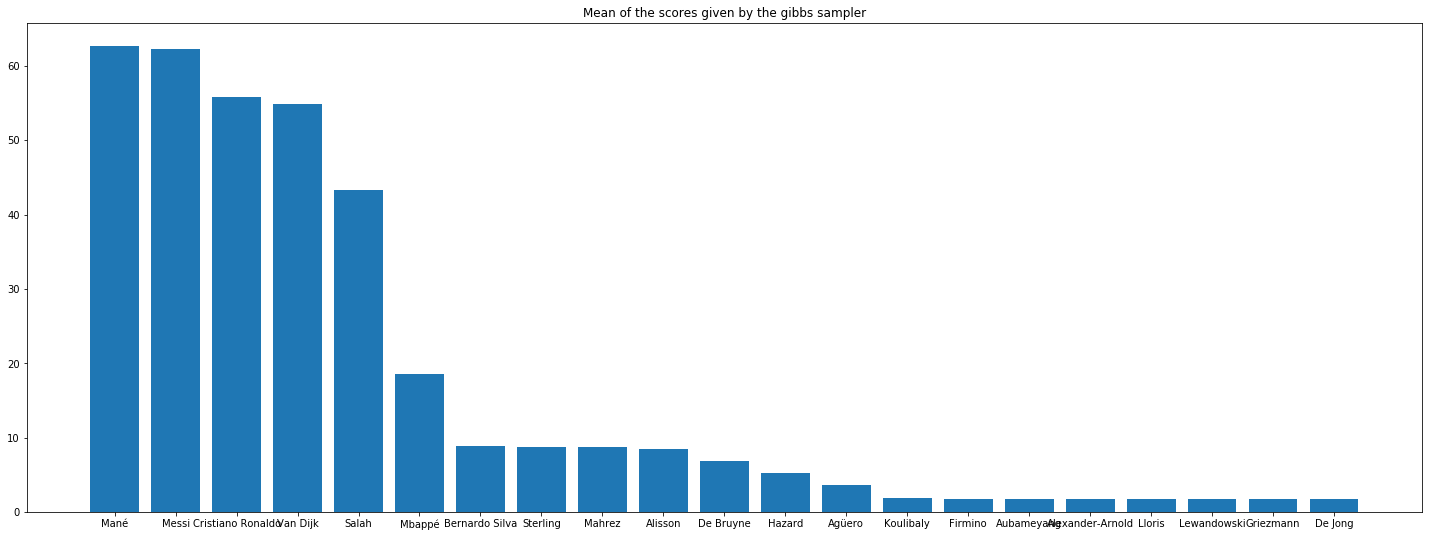

In [349]:
plt.figure(figsize = (25,9))
plt.title("Mean of the scores given by the gibbs sampler")
plt.bar(np.array(list(scorer.dict_item_to_number.keys()))[sorting],np.mean(w_list_mat.T,axis= 1)[sorting])
print(w_star_mean)

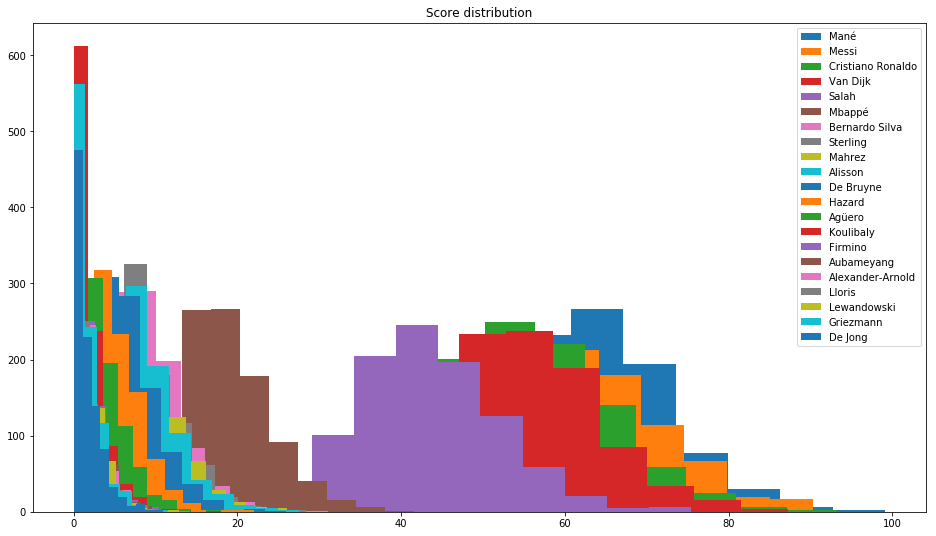

In [350]:
player_in_order = np.array(list(scorer.dict_item_to_number.keys()))[sorting]
score_in_order = w_list_mat.T[sorting,:]
plt.figure("Score distribution for each player", figsize = (16,9))
plt.clf()
plt.title("Score distribution")
for i,player in enumerate(player_in_order):  
    plt.hist(score_in_order[i],label = player)
    plt.legend()

In [97]:
player_in_order

array(['Messi', 'Mané', 'Van Dijk', 'Cristiano Ronaldo', 'Salah',
       'Mbappé', 'Alisson', 'Mahrez', 'Bernardo Silva', 'Sterling',
       'De Bruyne', 'Hazard', 'Agüero', 'Firmino', 'Koulibaly',
       'Griezmann', 'Lewandowski', 'De Jong', 'Alexander-Arnold',
       'Lloris', 'Aubameyang'], dtype='<U17')

## Dynamic

In [438]:
'''
Goal :  estimate the weights w_tk
w_tk should reprensent the proba to pick movie k at time t in a random country when looking at the top-5 box-office
w_t* is the weight associated to any movie that is not in the list

Warning : for N_ite = 10**5, the code is quite long to be executed (1-2 hours on my laptop)
'''


import numpy as np
import numpy.random as rnd
from scipy.stats import gamma
from scipy.stats import poisson
import pandas as pd
import matplotlib.pylab as plt
from time import time

def zeroTruncPoisson(lam):
    k=1
    t=np.exp(-lam)*lam/(1-np.exp(-lam))
    if t==0 : return 1
    s=t
    u=rnd.random()
    while s<u :
        k=k+1
        t=t*lam/k
        s=s+t
        if t<10**-100 : return 1        #in order to avoid too small or too large lambda
    return k



class gibbs_update_dynamic_model():

    def __init__(self,rankings,items,prior_alpha):
        self.rankings = np.array(rankings)
        self.items = np.array(items)

        self.a = prior_alpha[0]
        self.b = prior_alpha[1]
        self.alpha = rnd.gamma(self.a,self.b)
        self.tau = 1
        self.phi = 10**-5           #explodes when phi is too large

        #dimensions
        self.L = np.shape(rankings)[0]
        self.m = np.shape(rankings)[2]
        self.T = np.shape(rankings)[1]
        self.K = np.shape(items)[0]

        self.G = np.ones(self.T)
        self.w = np.ones((self.T,self.K))/self.K
        self.wstar = np.zeros(self.T)
        self.c = np.ones((self.T,self.K))
        self.cstar = np.zeros(self.T)
        self.Z = np.ones((self.T,self.L,self.m))
        self.x = np.zeros(self.T)
        self.delta_tlik = np.ones((self.T,self.L,self.m,self.K))
        
        for t in range(self.T):
            for l,ranking in enumerate(np.transpose(rankings, (1, 0, 2))[t]):
                for item,k in enumerate(items):
                    if item in ranking[:-1]:
                        position = ranking.index(item)
                        self.delta_lik[t,l,position+1:,k] = 0
                        
                        
        for i in range(self.m):
            for l in range(self.L):
                self.Z[:,l,i]=rnd.exponential(1-(i-1)/self.K,size=self.T)
        self.n = np.zeros((self.T,self.K))
        for t in range(self.T):
            for k in range(self.K):
                self.c[t,k]=rnd.poisson(self.phi*self.w[t,k])
                self.n[t,k]=1*np.sum(np.sum(self.items[k]==self.rankings[:,t,:]))

    
    def updatex(self):
        self.x[self.T-1] = np.sum(self.Z[self.T-1,:,:])
        for u in range(1,self.T):
            t = self.T-1-u
            self.x[t]=np.sum(self.Z[t,:,:])+self.phi*self.x[t+1]/(1+self.phi+self.x[t+1])
        
    def update1a(self):
        '''
        Update (G_t(X))_t, given alpha, tau, phi
        '''
        self.G[0]=rnd.gamma(self.alpha,self.tau)            #We update G_0(X), given alpha,tau
        for t in range(self.T-1):
            Mt=rnd.poisson(self.phi*self.G[t])
            self.G[t+1]=rnd.gamma(self.alpha+Mt,self.tau+self.phi) #Update G_{t+1}(X)

    def update1b(self):
        '''
        Update c_tk , given w_t,w_t+1,w_t*,w_t+1*,phi,alpha
        '''
        for t in range(self.T):
            for k in range(self.K):
                if self.n[t,k]==0:
                    if t<self.T-1:
                        if self.w[t+1,k]>0:
                            ctk_prop = zeroTruncPoisson(self.phi*self.w[t,k]) #we propose c_{t,k}~zero-truncPoisson
                            if rnd.random()< gamma.pdf(self.w[t+1,k],ctk_prop,self.tau+self.phi)/gamma.pdf(self.w[t+1,k],self.c[t,k],self.tau+self.phi):
                                self.c[t,k]=ctk_prop
                        else : #if w_{t+1,k}=0, then c_{t,k} can only be 0 or 1
                            if rnd.random() < 1/(1+self.phi*self.w[t,k]*(self.tau+self.phi)) : self.c[t,k]=0
                            else : self.c[t,k]=1
                    else:
                        ctk_prop = zeroTruncPoisson(self.phi*self.w[t,k])
                        self.c[t,k]=ctk_prop

        

        for k in range(self.K):
            #tau+
            tau_k = self.T
            while np.sum(self.n[tau_k:,k])==0: 
                tau_k=tau_k-1
            for t in [tau_k]:
                self.c[t,k]=rnd.poisson((1+self.phi)/(1+self.phi+self.x[t])*self.phi*self.w[t,k])
                if t<self.T-1:
                    self.w[t+1,k]=rnd.gamma(self.c[t,k],self.tau+self.phi+self.x[t+1])
            #tau-
            tau_k = 0
            while np.sum(self.n[:tau_k+1,k])==0: 
                tau_k=tau_k+1
            for t in [tau_k]:
                self.c[t,k]=rnd.poisson((1+self.phi)/(1+self.phi+self.x[t])*self.phi*self.w[t,k])
                if t<self.T-1:
                    self.w[t+1,k]=rnd.gamma(self.c[t,k],self.tau+self.phi+self.x[t+1])





    def update2a(self):
        '''
        Update alpha given Z, phi
        '''
        y = 0
        for u in range(1,self.T):
            t = self.T-1-u
            y = y - np.log((1+self.phi)/(1+self.phi+self.x[t])) 
        self.alpha = rnd.gamma(self.a+self.K,self.b+y+np.log(1+self.x[0]))

    def update2b(self):
        '''
        Update c* and w*
        '''

        self.wstar[0]=rnd.gamma(self.alpha,self.tau+self.x[0])
        for t in range(1,self.T):
            self.cstar[t-1] = rnd.poisson((1+self.phi)/(1+self.phi+self.x[t])*self.phi*self.wstar[t-1])
            self.wstar[t] = rnd.gamma(self.alpha+self.cstar[t-1],self.tau+self.phi+self.x[t])
        self.cstar[self.T-1] = rnd.poisson((1+self.phi)/(1+self.phi+self.x[self.T-1])*self.phi*self.wstar[self.T-2])

    def update3(self):
        '''
        Update w,w*
        '''
        for t in range(self.T):
            for k in range(self.K):
                if self.c[t,k]+self.c[t-1,k]+self.n[t,k]==0 : 
                    self.w[t,k] = 0
                else :
                    self.w[t,k] = rnd.gamma(self.n[t,k]+self.c[t-1,k]+self.c[t,k],self.tau+2*self.phi+np.sum(self.delta_tlik[t,:,:,k]*self.Z[t,:,:]))
            self.wstar[t] = rnd.gamma(self.alpha+self.cstar[t]+self.cstar[t-1],self.tau+2*self.phi+np.sum(self.Z[t,:,:]))

    def update4(self):
        '''
        Update Z
        '''
        for t in range(self.T):
            for i in range(self.m):
                for l in range(self.L):
                    self.Z[t,l,i]=rnd.exponential(1/(self.wstar[t]+np.sum(self.delta_tlik[t,l,i,:]*self.w[t,:])))


    def update5(self,sigma):
        '''
        Update phi
        '''
        epsilon = rnd.normal()
        phi_prop = self.phi*np.exp(sigma*epsilon) #proposal
        #MH acceptation step

        q = 0
        proba = (self.phi/phi_prop)**q
        for t in range(self.T-1):
            proba *= np.exp(-self.wstar[t+1]*(self.phi-phi_prop)/(self.tau+phi_prop+self.x[t])/(self.tau+self.phi+self.x[t])) \
                                        * ((self.tau+self.phi+self.x[t])/(self.tau+phi_prop+self.x[t]))**(self.alpha+self.cstar[t])
            for k in range(self.K):
                if self.w[t,k]>0:
                    proba *= np.exp(-self.w[t+1,k]*(self.phi-phi_prop)/(self.tau+phi_prop+self.x[t])/(self.tau+self.phi+self.x[t])) \
                                        * ((self.tau+self.phi+self.x[t])/(self.tau+phi_prop+self.x[t]))**(self.alpha+self.c[t,k])
        if rnd.random() < proba :
            self.phi = phi_prop

    def rescale(self):
        
        tot_mass = self.G/(np.sum(self.w,axis = 1)+self.wstar)
        self.w *= tot_mass.reshape(-1,1) #rescale w_0
        self.wstar *= tot_mass #rescale w_0*
        
        
    def update_step(self,sigma):
        '''
        One update step in Gibbs
        '''
        #tic = time()
        self.update1a()
        #print("1A")
        #print(tic-time())
        
        #tic = time()
        self.rescale()
        #print("Rescale")
        #print(tic-time())
        
        #tic = time()
        self.updatex()
        #print("X")
        #print(tic-time())

        #tic = time()
        self.update1b()
        #print("1B")
        #print(tic-time())

        #tic = time()
        self.update2a()
        #print("2A")
        #print(tic-time())

        #tic = time()
        self.update2b()
        #print("2B")
        #print(tic-time())

        #tic = time()
        self.update3()
        #print("3")
        #print(tic-time())

        #tic = time()
        self.update4()
        #print("4")
        #print(tic-time())

        #tic = time()
        self.update5(sigma)
        #print("5")
        #print(tic-time())





    def gibbs_algo(self,sigma,N_ite,N_sample):
        w_tab = []
        wstar_tab = []
        for j in range(N_ite):
            self.update_step(sigma)
            if j>=N_ite-N_sample :
                w_tab.append(self.w)
                wstar_tab.append(self.wstar)

        self.update3()
        return (w_tab,wstar_tab)






In [439]:
## data

us_weekly = pd.read_csv('us_weekly.csv')
uk_weekly = pd.read_csv('uk_weekly.csv')
fr_weekly = pd.read_csv('fr_weekly.csv')
de_weekly = pd.read_csv('de_weekly.csv')
rankings = np.array([np.array(us_weekly)[:5,:].T,np.array(uk_weekly)[:5,:].T,np.array(fr_weekly)[:5,:].T,np.array(de_weekly)[:5,:].T])
items = np.array(list(set(list(np.ndarray.flatten(rankings)))))

## parameters

a=0.1
b=0.1

sigma = 1.0
N_ite = 1000
N_sample = 500


In [440]:
rankings.shape

(4, 22, 5)

In [441]:
## execution

method = gibbs_update_dynamic_model(rankings,items,[a,b])

(w_tab,wstar_tab)=method.gibbs_algo(sigma,N_ite,N_sample)

/Users/rzhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/rzhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


In [442]:
method.w.shape

(22, 104)

In [443]:
method.Z.shape

(22, 4, 5)

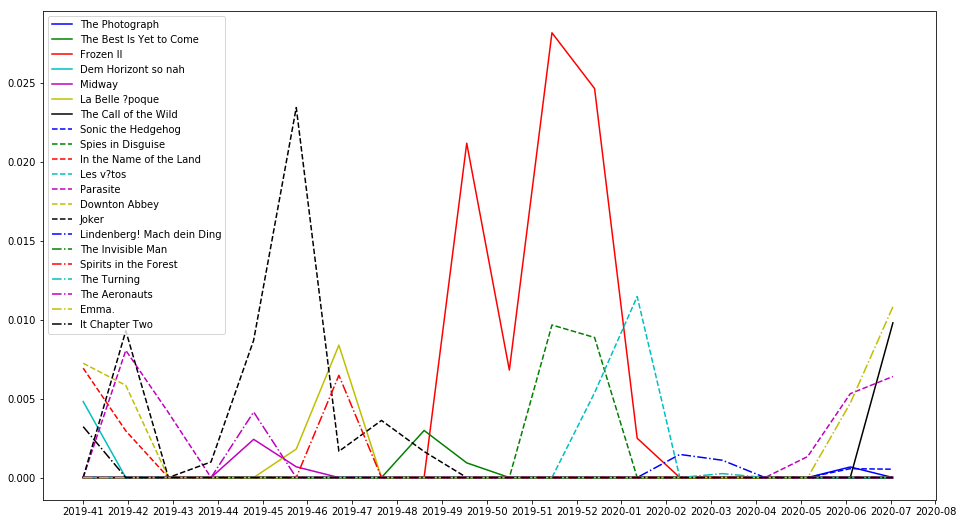

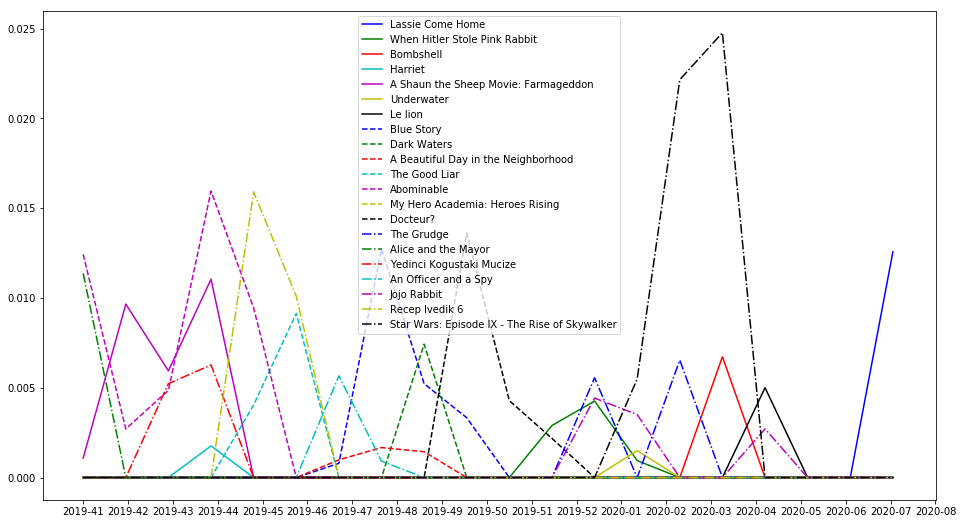

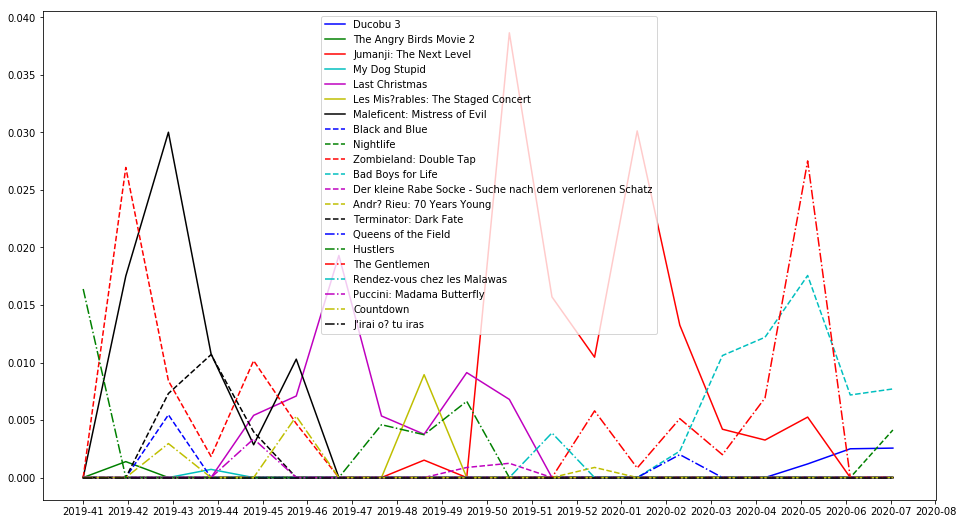

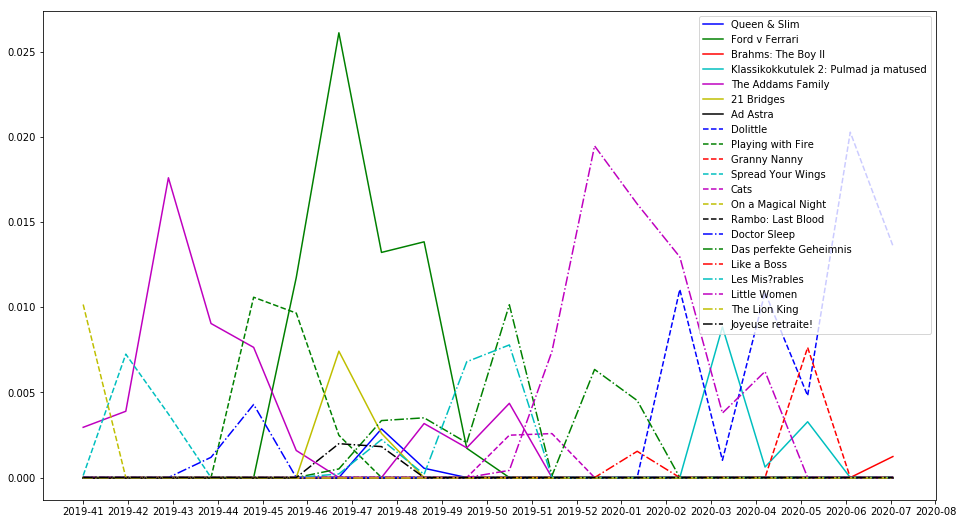

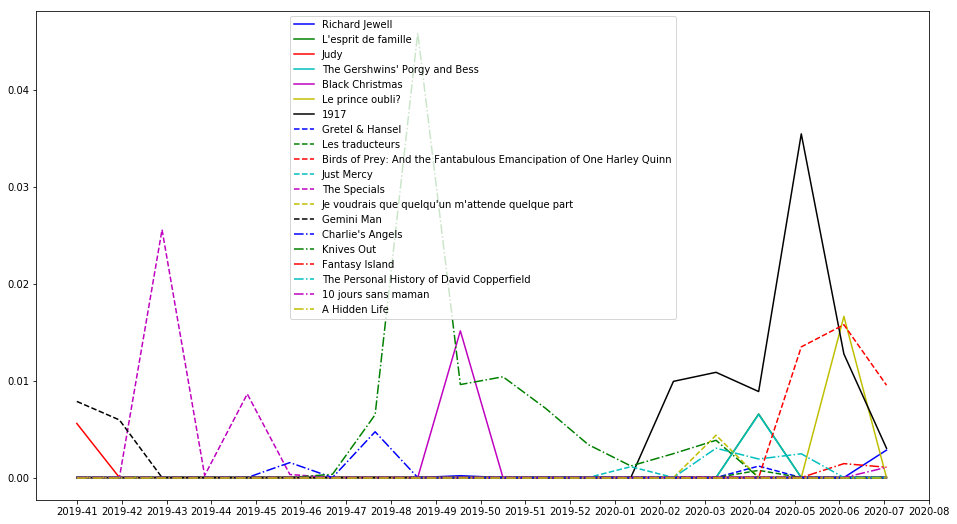

In [444]:
## plot

dates = np.array(['2019-40','2019-41','2019-42','2019-43','2019-44','2019-45','2019-46','2019-47','2019-48','2019-49','2019-50','2019-51','2019-52','2020-01','2020-02','2020-03','2020-04','2020-05','2020-06','2020-07','2020-08','2020-09'])


# mean of the results + normalization
w_mean = np.zeros((method.T,method.K))
wstar_mean = np.zeros(method.T)
for i in range(25):
    w_mean = w_mean + 1/25*w_tab[i][:,:]/(np.array([(np.sum(w_tab[i],axis=1)+wstar_tab[i])]).T.dot(np.ones((1,method.K))))
    wstar_mean = wstar_mean + 1/25*wstar_tab[i][:]/(np.sum(w_tab[i],axis=1)+wstar_tab[i])


linestyles = ['b-','g-','r-','c-','m-','y-','k-','b--','g--','r--','c--','m--','y--','k--','b-.','g-.','r-.','c-.','m-.','y-.','k-.']
for j in range(5):
    n_line = 0
    plt.figure(j,figsize =(16,9))
    for k in range(method.K):
        if k%5==j:
            plt.plot(w_mean[1:-1,k],linestyles[n_line],label=method.items[k])
            n_line+=1

    plt.legend()
    plt.xticks(np.linspace(0,method.T-2,method.T-2),dates[1:method.T-1])
    plt.show()

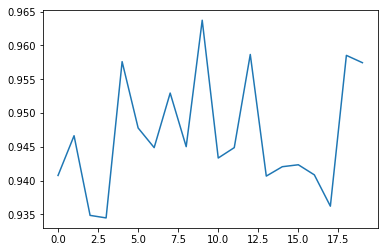

In [436]:
plt.figure(5)
plt.plot(np.array([wstar_mean[1:-1]]).T,label='w_t*')

In [376]:
np.sum(method.w,axis = 1).shape

(22,)

In [377]:
method.wstar.shape

(22,)